This notebook generates and runs queries to download Gaia data for the region around the GD-1 stream.

Note that we don't use the Gaia-PS1 crossmatch in the Gaia archive because of the aggressive quality cuts the Gaia team applied when loading the PS1 data, so here we only download Gaia data and later cross-match to PS1 using MAST.

In [1]:
import pathlib
import warnings

# Third-party
import astropy.coordinates as coord
import astropy.table as at
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tqdm import tqdm

import gala.coordinates as gc
import gala.dynamics as gd
from pyia import GaiaData
from astroquery.gaia import Gaia

In [2]:
Gaia.login(
    credentials_file=pathlib.Path('~/.gaia/archive.login').expanduser()
)

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


In [3]:
data_path = pathlib.Path('../data/gd1-polygon/').resolve()
data_path.mkdir(exist_ok=True, parents=True)

In [4]:
gaia_cols = [
    'source_id', 
    'ra', 'dec', 
    'parallax', 'parallax_error', 
    'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 
    'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 
    'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 
    'parallax_pmdec_corr', 'pmra_pmdec_corr', 
    'phot_g_mean_mag', 'phot_g_mean_flux_over_error', 
    'phot_bp_mean_mag', 'phot_bp_mean_flux_over_error', 
    'phot_rp_mean_mag', 'phot_rp_mean_flux_over_error', 
    'ruwe'
]

In [5]:
q_base = '''
SELECT {columns}
FROM gaiadr3.gaia_source
WHERE parallax < 1 AND bp_rp > -1 AND bp_rp < 3 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       {c[0].ra.degree}, {c[0].dec.degree}, 
                       {c[1].ra.degree}, {c[1].dec.degree}, 
                       {c[2].ra.degree}, {c[2].dec.degree}, 
                       {c[3].ra.degree}, {c[3].dec.degree})) = 1
'''

In [7]:
queries = []
jobs = {}
for i, l in enumerate(np.arange(-100, 20, 10)):
    print(l)
    
    fn = data_path / f'gd1_{l:.0f}.fits'
    if fn.exists():
        print(f'{fn!s} exists...skipping')
        continue

    corners = gc.GD1Koposov10(
        phi1=[l, l, l+10, l+10]*u.deg, 
        phi2=[-10, 5, 5, -10]*u.deg
    )
    corners_icrs = corners.transform_to(coord.ICRS())
    q = q_base.format(
        columns=', '.join(gaia_cols), 
        c=corners_icrs
    )
        
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        job = Gaia.launch_job_async(q, name=f'GD1_{i:02d}',
                                    background=True)
    jobs[fn] = job

-100
-90
-80
-70
-60
-50
-40
-30
-20
-10
0
10


In [8]:
if jobs:
    for fn, job in tqdm(jobs.items(), total=len(jobs)):
        tbl = job.get_results()

#         for c in tbl.colnames: # hack to make sure object arrays are string
#             if tbl[c].dtype == object:
#                 tbl[c] = np.array(tbl[c]).astype(str)
        tbl.write(fn, overwrite=True)

100%|██████████| 12/12 [32:42<00:00, 163.56s/it] 


# Combine tables

In [9]:
from numpy.lib.recfunctions import stack_arrays

In [10]:
all_filename = pathlib.Path('../data/gd1-dr3-polygon.fits')
if not all_filename.exists():
    arrs = []
    for filename in data_path.glob('*.fits'):
        arrs.append(np.array(fits.getdata(filename)))
    arr = stack_arrays(arrs, asrecarray=True, usemask=False)
    
    t = at.Table(arr)
    
    c_gd1 = coord.SkyCoord(
        t['ra'] * u.deg,
        t['dec'] * u.deg,
    ).transform_to(gc.GD1Koposov10())
    t['gd1_phi1'] = c_gd1.phi1.degree
    t['gd1_phi2'] = c_gd1.phi2.degree
    
    t.write(all_filename, overwrite=True)

In [11]:
g = GaiaData(all_filename)

In [12]:
c_gd1 = g.get_skycoord(
    distance=8.5*u.kpc, 
    radial_velocity=0*u.km/u.s
).transform_to(gc.GD1Koposov10())
c_gd1 = gc.reflex_correct(c_gd1)

/mnt/home/apricewhelan/anaconda3/lib/python3.9/site-packages/gala/coordinates/gd1.py:104: GalaDeprecationWarning: This frame is deprecated. Use GD1Koposov10 instead.
  warnings.warn("This frame is deprecated. Use GD1Koposov10 instead.",



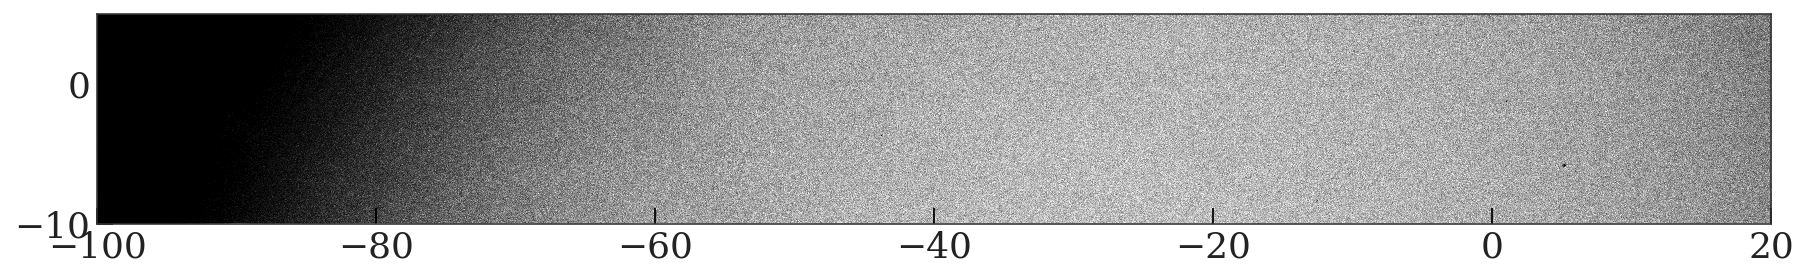

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(c_gd1.phi1.wrap_at(180*u.deg),
        c_gd1.phi2, 
        marker=',', linestyle='none', alpha=0.05)

ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)

ax.set_aspect('equal')

6


(-10.0, 5.0)

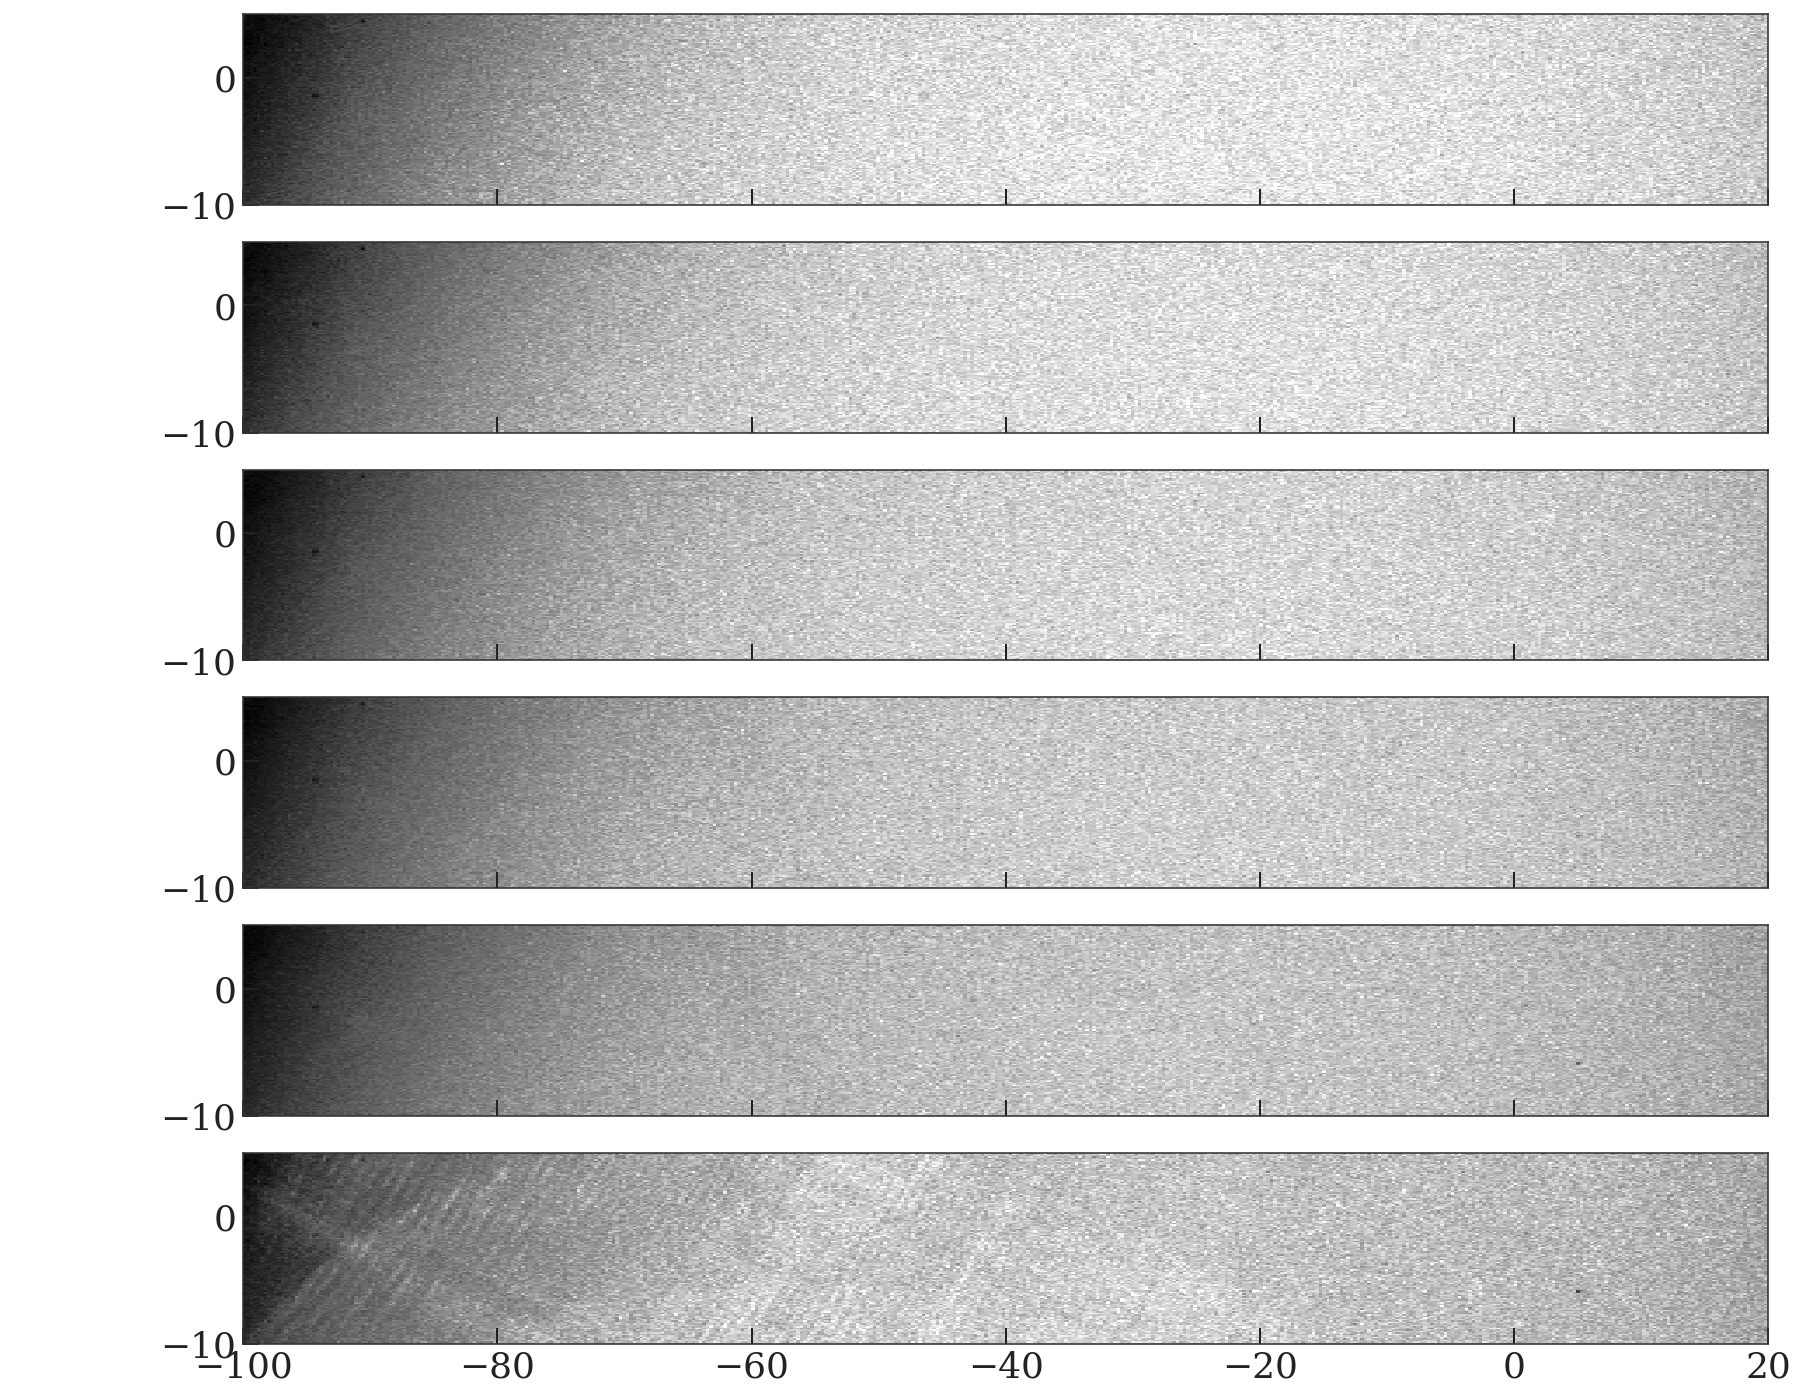

In [17]:
G_bins = np.arange(18, 21+0.5, 0.5) * u.mag
nbins = len(G_bins) - 1
print(nbins)

fig, axes = plt.subplots(nbins, 1, figsize=(15, 1.6 * nbins), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

for ax, (l, r) in zip(axes, zip(G_bins[:-1], G_bins[1:])):
    mask = (g.phot_g_mean_mag >= l) & (g.phot_g_mean_mag < r)
    ax.hist2d(
        c_gd1.phi1.wrap_at(180*u.deg).value[mask],
        c_gd1.phi2.value[mask], 
        bins=(np.linspace(-120, 20, 512),
              np.linspace(-10, 5, 128)),
        norm=mpl.colors.LogNorm(),
        cmap='Greys'
    )
    ax.text(-118, 4.5, f'$G=${l.value:.1f}–{r.value:.1f}', 
            color='w', fontsize=15, ha='left', va='top')
    ax.set_aspect('equal')

ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)

In [15]:
from scipy.ndimage import gaussian_filter

(-10.0, 10.0)

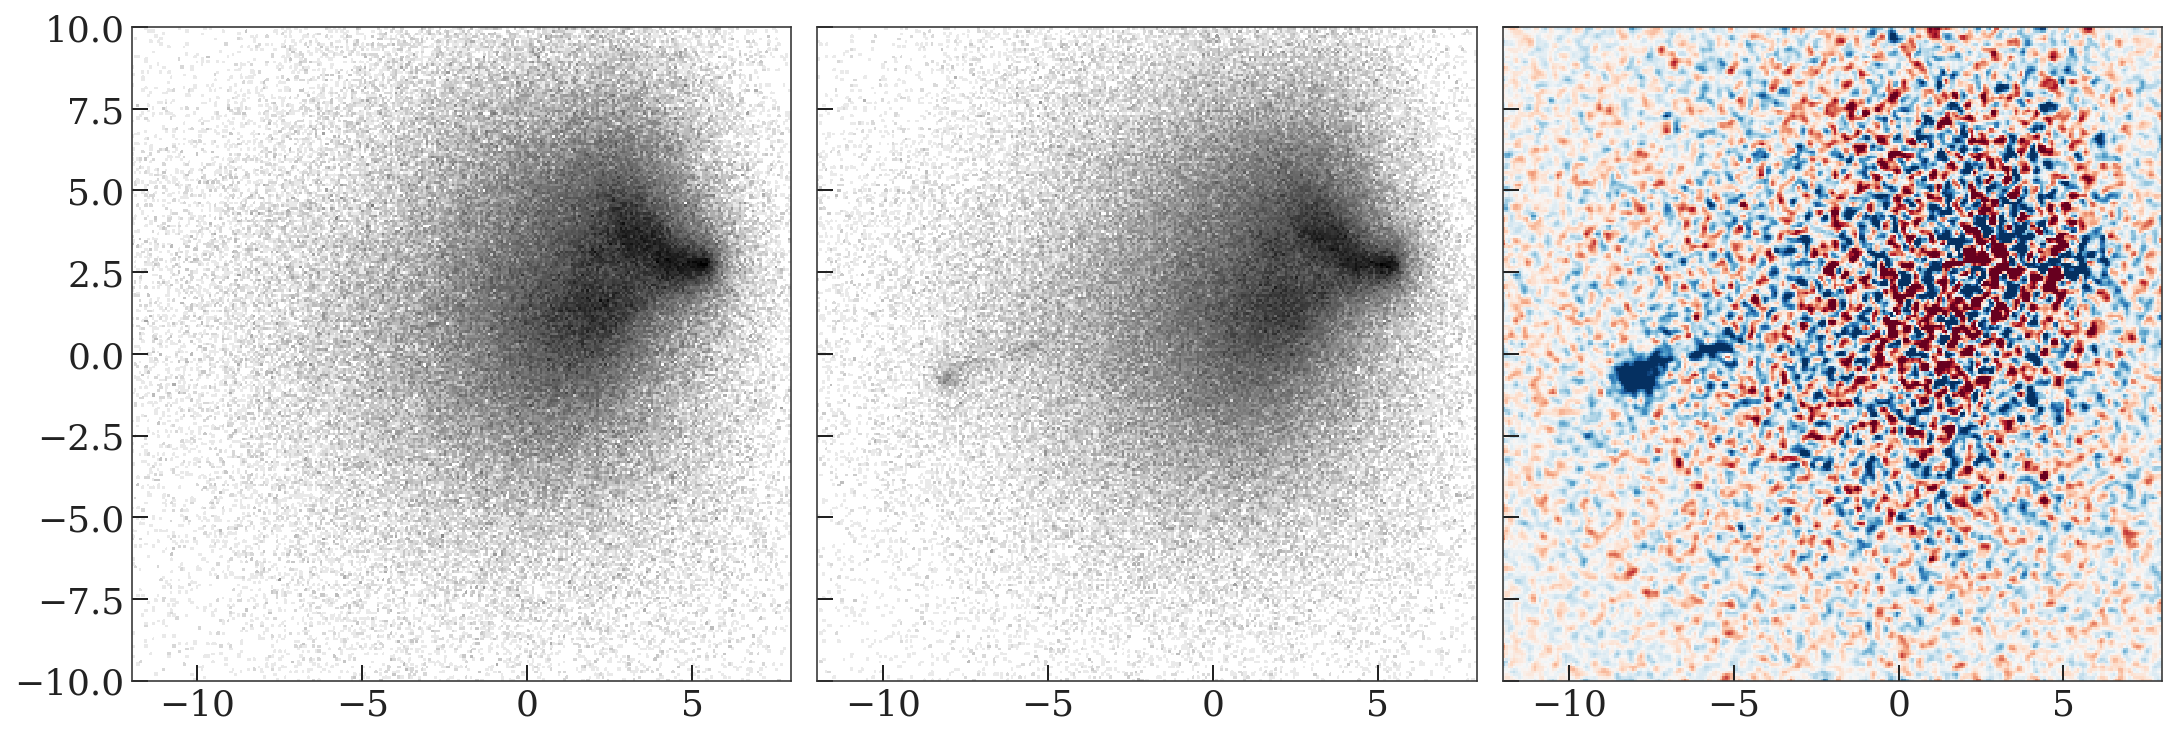

In [16]:
phi1_mask = (
    (c_gd1.phi1.wrap_at(180*u.deg) > -80*u.deg) & 
    (c_gd1.phi1.wrap_at(180*u.deg) < 10*u.deg)
)

phi2_mask_on = (np.abs(c_gd1.phi2) < 1*u.deg)
phi2_mask_off = (
    ((c_gd1.phi2 > 1.5*u.deg) & (c_gd1.phi2 < 2.5*u.deg)) |
    ((c_gd1.phi2 > -3*u.deg) & (c_gd1.phi2 < -2*u.deg))
)

bins = (
    np.linspace(-12, 8, 256),
    np.linspace(-10, 10, 256),
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

ax = axes[0]
_mask = phi1_mask & phi2_mask_off
H_off, xe, ye, *_ = ax.hist2d(
    c_gd1.pm_phi1_cosphi2[_mask].value, 
    c_gd1.pm_phi2[_mask].value, 
    bins=bins,
    norm=mpl.colors.LogNorm(),
    cmap='Greys'
)

ax = axes[1]
_mask = phi1_mask & phi2_mask_on
H_on, xe, ye, *_ = ax.hist2d(
    c_gd1.pm_phi1_cosphi2[_mask].value, 
    c_gd1.pm_phi2[_mask].value, 
    bins=bins,
    norm=mpl.colors.LogNorm(),
    cmap='Greys'
)

axes[2].pcolormesh(
    xe, ye, 
    # (gaussian_filter(H_on, 1) - gaussian_filter(H_off, 1)).T,
    gaussian_filter((H_on - H_off), 1).T,
    cmap='RdBu',
    vmin=-2, 
    vmax=2
)

ax.set_xlim(-12, 8)
ax.set_ylim(-10, 10)